In [236]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [237]:
import torch

In [238]:
import pandas as pd

## We load the temperature data from the csv file and sort the data into matrices

In [239]:
class read_in_data(object):
    def __init__(self, filename):
        # Open the file
        fid_in = open(filename,"r")
        
        # The first line contains the headers
        dummy = fid_in.readline()
        
        timestamps = []
        depth      = []
        temp       = []
        fluo       = []
        
        # Loop through the file and store the data in the 
        # appropriate lists
        for dummy_line in fid_in:
            dummy_line = dummy_line.strip().split(",")

            date = datetime.strptime(dummy_line[1]+ " " +dummy_line[2], '"%m/%d/%y" "%H:%M:%S"')
            
            
            if dummy_line[3] == 'NA':
                continue
            else:
                timestamps.append(date)

                depth.append(float(dummy_line[3]))

                temp.append(float(dummy_line[4]))
                try:
                    fluo.append(float(dummy_line[5]))
                except:
                    fluo.append(np.nan)
        
        fid_in.close()
        
        self.timestamps = np.array(timestamps)
        self.depth = np.array(depth)
        self.temp = np.array(temp)
        self.fluo = np.array(fluo)
    
        # Convert the timeseries into matrices 
        # It will involve a linear interpolation in the vertical
        self.vertical_consistency(dz = 0.2)
        
    def vertical_consistency(self, dz=0.2):
        
        # Initialize the lists linked to the matrices
        MTemp = []
        MDept = np.arange(0,self.depth.max()+dz,dz)
        MTime = []
        MFluo = []
        
        
        # The end of a profile will be marked by a smaller depth in the next index
        # Here we substract the neighbouring depth and check where it is megative
        # Assuming the first index in the time series is the beginning of a profile
        dep_diff = self.depth[1::] - self.depth[0:-1]
        
        # Where dep_diff <0 That's the end of a profile
        loc_end_prof = np.squeeze(np.where(dep_diff<0.))
  
        # Now we will loop through the indices we created to extract the profiles
        # It seems the profiler stops mid depth in between profiles, we will have 
        # to take this into account
        prof_start = 0
        

        for i in range(0,len(loc_end_prof),1):
            prof_end = loc_end_prof[i]+1
            
            profTime = self.timestamps[prof_start]
            profTemp = self.temp[prof_start:prof_end]
            profDept = self.depth[prof_start:prof_end]
            profFluo = self.fluo[prof_start:prof_end]
        
            # The instances when the profiler is mid depth, the profD should have
            # a length of 1. We don't focus on them, therefore, if we see one, we skip
            if len(profDept) <= 10:
                pass
            else:
                MTime.append(profTime)
                dummy_temp = np.interp(MDept, profDept, profTemp)
                MTemp.append(dummy_temp)
                
                dummy_fluo = np.interp(MDept, profDept, profFluo)
                MFluo.append(dummy_fluo)
            
            prof_start = prof_end # Beginning of next profile
            
        self.MTime = np.array(MTime)
        self.MTemp = np.array(MTemp) # In this configuration MTemp has the following dimensions (Nt, Nz)
        self.MDept = np.array(MDept)
        self.MFluo = np.array(MFluo)

temperature_data = read_in_data("WaterTempData/TeaIsland.csv")
#temperature_data = read_in_data("WaterTempData/AnthonysNose.csv")

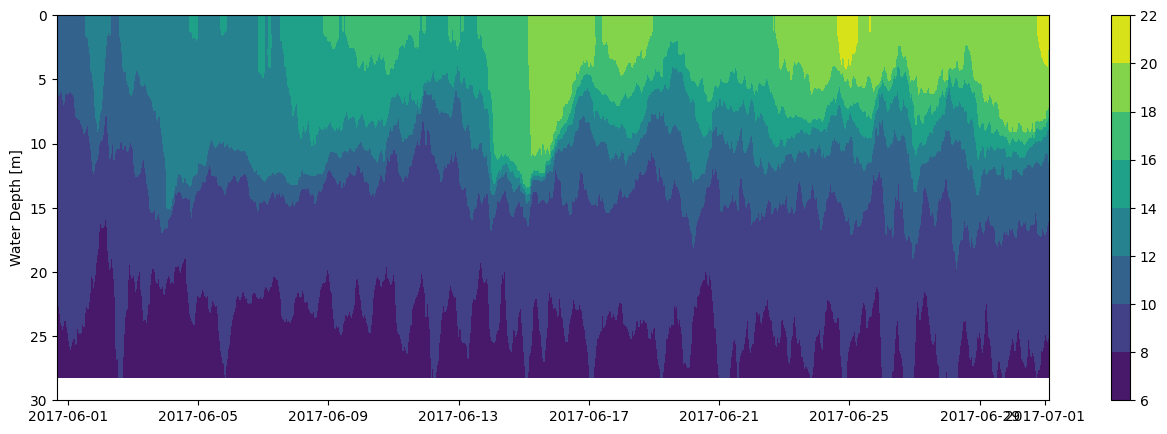

In [240]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
CS = ax.contourf(temperature_data.MTime, temperature_data.MDept, temperature_data.MTemp.T)
CB = plt.colorbar(CS)
ax.set_ylim((30,0))
ax.set_ylabel("Water Depth [m]")
plt.show()

## Using AutoEncoder on the temperature data

In [241]:
# Prepare the loader to generate batches for the learning process
loader = torch.utils.data.DataLoader(dataset = (temperature_data.MTemp - temperature_data.MTemp.mean())/temperature_data.MTemp.std(),
                                     batch_size = 200,
                                     shuffle = True)

In [259]:
## AutoEncoder model
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self, sizein):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(sizein, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 2)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, sizein)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [260]:
# Model Initialization
model = AE(temperature_data.MTemp.shape[1])
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [261]:
epochs = 100
outputs = []
losses = []
for epoch in range(epochs):
    for image in loader:

        # Temperature data are 
        image = image.float()
        
        # Output of Autoencoder
        reconstructed = model(image)
        
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
    outputs.append((epochs, image, reconstructed))


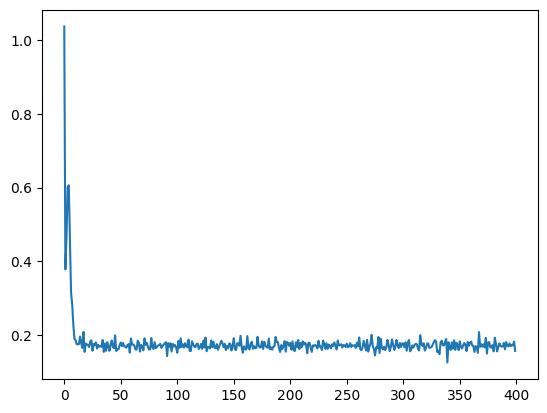

In [262]:
plt.plot(np.array(losses))

## Compariso between modeled and original water temperature

In [263]:
data_processed = (temperature_data.MTemp - temperature_data.MTemp.mean())/temperature_data.MTemp.std()
data_tensor = torch.from_numpy(data_processed)

In [264]:
reconstructed = model(data_tensor.float())
print(reconstructed.shape)
print(temperature_data.MDept.shape)
print(temperature_data.MTime.shape)

torch.Size([728, 142])
(142,)
(728,)


(30.0, 0.0)

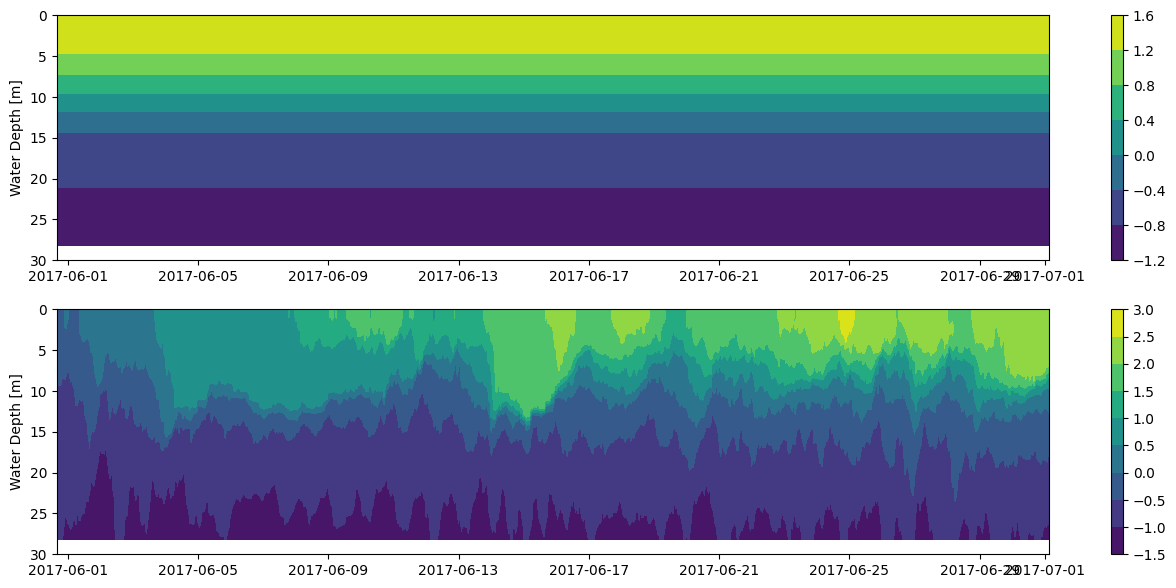

In [265]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(211)
CS1 = ax1.contourf(temperature_data.MTime, temperature_data.MDept,reconstructed.detach().numpy().T)
CB1 = plt.colorbar(CS1)
ax1.set_ylabel("Water Depth [m]")
ax1.set_ylim((30,0))

ax2 = fig.add_subplot(212)
CS2 = ax2.contourf(temperature_data.MTime, temperature_data.MDept,data_processed.T)
CB2 = plt.colorbar(CS2)
ax2.set_ylabel("Water Depth [m]")
ax2.set_ylim((30,0))

## Try without batch learning

In [266]:
# Model Initialization
model2 = AE(temperature_data.MTemp.shape[1])
 
# Validation using MSE Loss function
loss_function2 = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer2 = torch.optim.Adam(model2.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [267]:
epochs = 100
outputs = []
losses = []
# Temperature data are 
image = data_tensor.float()
for epoch in range(epochs):


    
    
    # Output of Autoencoder
    reconstructed = model2(image)
    
    # Calculating the loss function
    loss = loss_function2(reconstructed, image)
    
    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
    # Storing the losses in a list for plotting
    losses.append(loss.detach().numpy())
    outputs.append((epochs, image, reconstructed))


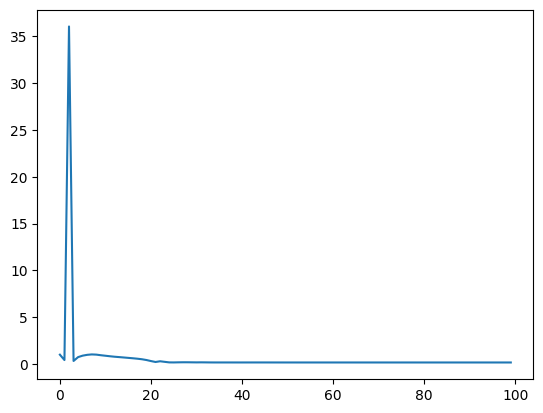

In [268]:
plt.plot(np.array(losses))

Text(0, 0.5, 'Water Depth [m]')

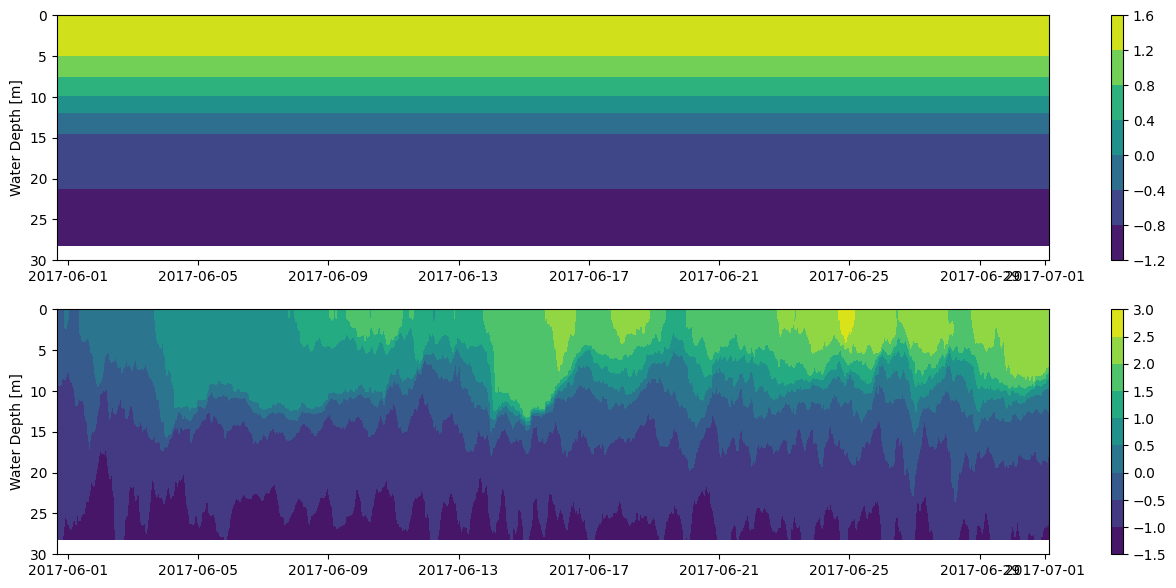

In [269]:
reconstructed = model2(image)
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(211)
CS1 = ax1.contourf(temperature_data.MTime, temperature_data.MDept,reconstructed.detach().numpy().T)
CB1 = plt.colorbar(CS1)
ax1.set_ylabel("Water Depth [m]")
ax1.set_ylim((30,0))

ax2 = fig.add_subplot(212)
CS2 = ax2.contourf(temperature_data.MTime, temperature_data.MDept,data_processed.T)
CB2 = plt.colorbar(CS2)
ax2.set_ylim((30,0))
ax2.set_ylabel("Water Depth [m]")

### With the current configuration, it seems the auto-encoder somewhat gives information on the average thermal stratification. However, the temporal information seems to be lost completely. 

Text(0, 0.5, 'Water Depth [m]')

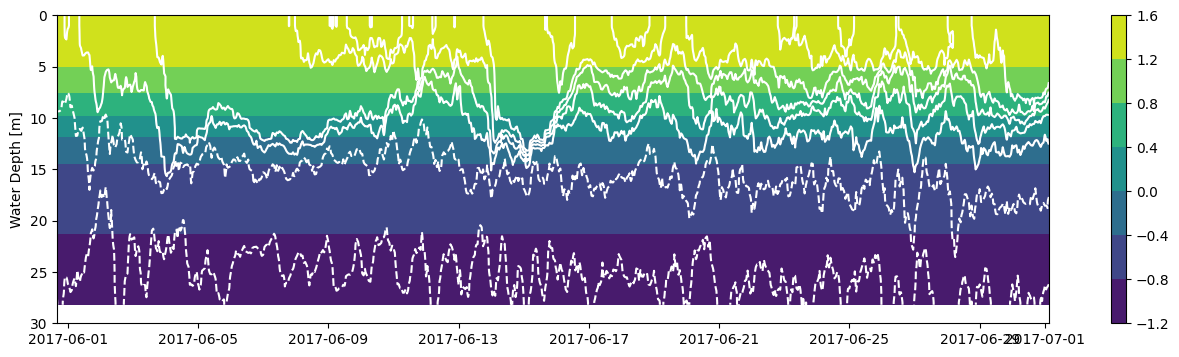

In [270]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(111)
CS1 = ax1.contourf(temperature_data.MTime, temperature_data.MDept,reconstructed.detach().numpy().T)
CB1 = plt.colorbar(CS1)

# Plot the contours of the water temperature to illustrate the 
CS2 = ax1.contour(temperature_data.MTime, temperature_data.MDept,data_processed.T, levels=np.arange(-1.5, 3.1,0.5), colors="w")
ax1.set_ylim((30,0))
ax1.set_ylabel("Water Depth [m]")

In [271]:
# Let's plot the temporally averaged profile and compare to the reconstructed

In [272]:
true_temp = data_processed.T.mean(axis=1)
reco_temp = reconstructed.detach().numpy().T.mean(axis=1)

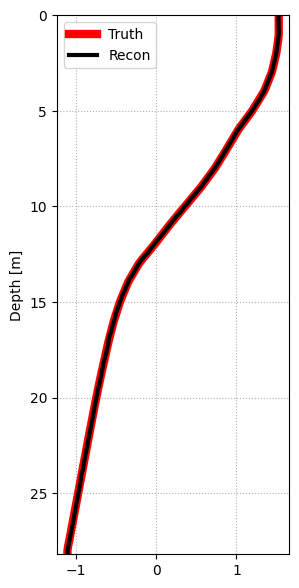

In [273]:
fig = plt.figure(figsize=(3,7))
ax1 = fig.add_subplot(111)
lab1, = ax1.plot(true_temp, temperature_data.MDept, color="r", lw=6, label="Truth")
lab2, = ax1.plot(reco_temp, temperature_data.MDept, color="k", lw=3, label="Recon")
ax1.legend(handles=[lab1,lab2])
ax1.set_ylabel("Depth [m]")
ax1.set_ylim((temperature_data.MDept.max(), temperature_data.MDept.min()))
ax1.grid(True, linestyle=":")

### Let's look at the latent space (Outputs from the encoder)

In [274]:
reconstructed = model2.encoder(image)

In [275]:
reconstructed

tensor([[0.0947, 0.2570],
        [0.0947, 0.2570],
        [0.0947, 0.2570],
        ...,
        [0.0947, 0.2570],
        [0.0947, 0.2570],
        [0.0947, 0.2570]], grad_fn=<AddmmBackward0>)